In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import sys
sys.path.append('../')
from utils import *

In [2]:
is_kaggle = False

if is_kaggle:
    base_dir = '/kaggle/input'
    data_dir = f'{base_dir}/linking-writing-processes-to-writing-quality'
    output_dir = '/kaggle/working'
else:
    base_dir = '../'
    data_dir = f'{base_dir}/data'
    models_dir = f'{base_dir}/models'

In [3]:
train_logs_df = pd.read_csv(f'{data_dir}/train_logs.csv')
train_scores_df = pd.read_csv(f'{data_dir}/train_scores.csv')

test_logs_df = pd.read_csv(f'{data_dir}/test_logs.csv')

In [4]:
essayConstructor = EssayConstructor()
train_essays = essayConstructor.getEssays(train_logs_df)

100%|██████████| 2471/2471 [00:06<00:00, 395.38it/s]


In [5]:
train_essays.index = train_essays["id"]
train_essays.index.name = None
train_essays.drop(columns=["id"], inplace=True)
train_essays.head()

,essay
001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."


In [6]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essays)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)

In [7]:
# Paragraph features for train dataset
train_paragraph_df = split_essays_into_paragraphs(train_essays)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [8]:
test_essays = essayConstructor.getEssays(test_logs_df)
test_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(test_essays))
test_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(test_essays))

100%|██████████| 3/3 [00:00<00:00, 3003.80it/s]


In [9]:
preprocessor = Preprocessor(seed=42)
train_feats = preprocessor.make_feats(train_logs_df)
test_feats = preprocessor.make_feats(test_logs_df)
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
train_feats = train_feats.drop(columns=nan_cols)
test_feats = test_feats.drop(columns=nan_cols)

Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [01:55<00:00,  3.49s/it, column=word_count_change100, method=last]       


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 9467.35it/s] 
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 8609.69it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 2471/2471 [00:00<00:00, 9767.00it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 10089.85it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 9503.92it/s]


Engineering input words data


c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:382: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:383: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:384: PerformanceWarning: DataFrame is highly fragmented.  This 

Engineering ratios data
Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [00:02<00:00, 15.78it/s, column=word_count_change100, method=last]       


Engineering activity counts data


100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:382: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:383: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']


Engineering input words data
Engineering ratios data


c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:384: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:385: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']


In [10]:
train_agg_fe_df = train_logs_df.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

test_agg_fe_df = test_logs_df.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

train_feats = train_feats.merge(train_agg_fe_df, on='id', how='left')
test_feats = test_feats.merge(test_agg_fe_df, on='id', how='left')

In [11]:
# Idea is based on features introduced in Section 3 of this research paper: https://files.eric.ed.gov/fulltext/ED592674.pdf

data = []

for logs in [train_logs_df, test_logs_df]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores_df, on='id', how='left')

In [12]:
# Adding the additional features to the original feature set

train_feats = train_feats.merge(train_sent_agg_df, on='id', how='left')
train_feats = train_feats.merge(train_paragraph_agg_df, on='id', how='left')
# test_feats = test_feats.merge(test_sent_agg_df, on='id', how='left')
# test_feats = test_feats.merge(test_paragraph_agg_df, on='id', how='left')

## Copy from keyboard notebook

In [13]:
# Creates two shift variables which lag the original variable by 1 and 2 periods respectively.
event_df = train_logs_df[['id', 'event_id', 'down_event']].copy(deep=True)

event_df['down_event_shift_1'] = event_df['down_event'].shift(periods=1)
event_df['down_event_shift_2'] = event_df['down_event'].shift(periods=2)

event_df = event_df[['id', 'event_id', 'down_event_shift_2', 'down_event_shift_1', 'down_event']]

ctrl_left_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'] == 'ArrowLeft')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_right_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'] == 'ArrowRight')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_shift_left_df = ((event_df['down_event_shift_2'] == 'Control') & (event_df['down_event_shift_1'] == 'Shift') & (event_df['down_event'] == 'ArrowLeft')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_shift_right_df = ((event_df['down_event_shift_2'] == 'Control') & (event_df['down_event_shift_1'] == 'Shift') & (event_df['down_event'] == 'ArrowRight')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_bksp_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'] == 'Backspace')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_c_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'c')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_v_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'v')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_x_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'x')).groupby(event_df['id']).sum().reset_index(name='count')

# Creating a DataFrame that contains all counts at an id level.

kb_shortcut_df = pd.DataFrame(event_df['id'].unique(), columns=['id'])

kb_shortcut_df['ctrl_left_cnt'] = ctrl_left_df['count']
kb_shortcut_df['ctrl_right_cnt'] = ctrl_right_df['count']
kb_shortcut_df['ctrl_shift_left_cnt'] = ctrl_shift_left_df['count']
kb_shortcut_df['ctrl_shift_right_cnt'] = ctrl_shift_right_df['count']
kb_shortcut_df['ctrl_bksp_cnt'] = ctrl_bksp_df['count']
kb_shortcut_df['ctrl_c_cnt'] = ctrl_c_df['count']
kb_shortcut_df['ctrl_v_cnt'] = ctrl_v_df['count']
kb_shortcut_df['ctrl_x_cnt'] = ctrl_x_df['count']

mouse_event_df = pd.DataFrame(train_logs_df['id'].unique(), columns=['id'])

# Calculating the proportion of mouse click events
mouse_event_df['mouse_event_cnt'] = train_logs_df.groupby(train_logs_df['id'])['down_event'].apply(lambda x: (x.isin(['Leftclick', 'Rightclick', 'Middleclick', 'Unknownclick']).sum())).reset_index()['down_event']

mouse_event_df['all_event_cnt'] = train_logs_df.groupby(train_logs_df['id'])['event_id'].max().reset_index()['event_id']

mouse_event_df['mouse_event_perc'] = (mouse_event_df['mouse_event_cnt']/mouse_event_df['all_event_cnt'])*100.0

# Combining both sets of features into one DataFrame
kb_features = ['ctrl_left_cnt', 'ctrl_right_cnt', 'ctrl_shift_left_cnt', 'ctrl_shift_right_cnt', 'ctrl_bksp_cnt', 
               'ctrl_c_cnt', 'ctrl_v_cnt', 'ctrl_x_cnt']

ms_features = ['mouse_event_perc']

ms_kb_df = pd.DataFrame(train_logs_df['id'].unique(), columns=['id'])

for col in kb_features:
    ms_kb_df[col] = kb_shortcut_df[col]

for col in ms_features:
    ms_kb_df[col] = mouse_event_df[col]
    
# ms_kb_df['score'] = train_scores_df['score'] 

In [14]:
train_feats = train_feats.merge(ms_kb_df, on='id', how='left')

#### Copy from https://www.kaggle.com/code/magnussesodia/writing-processes-feature-generation

In [15]:
X_ = gen_features(train_logs_df)

train_feats = train_feats.merge(X_, on='id', how='left')

#### Copy from https://www.kaggle.com/code/habedi/baseline-model-with-over-2000-features#2.2-Generating-new-features

In [16]:
feature_maker = FeatureMaker()
created_features = feature_maker.make_features(train_logs_df, name='Train Logs')

# train_feats = train_feats.merge(created_features, on='id', how='left')

--- Train Logs Feature Engineering ---
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 4
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 4
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 4
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100

=== Making features from numerical features ===
--- Making features from: event_count ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\groupby\groupby.py:1640: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:693: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: skew(x.dropna()),  # Skewness with NaN handling
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:694: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: kurtosis(x.dropna()),  # Kurtosis with NaN handling
c:\Users\luis.pinto1\AppData\Local\Programs\Python

--- Making features from: rolling_std_50 ---
--- Making features from: down_time ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: time_diff_up_2 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: time_diff_down_1 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: max_action_time ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\groupby\groupby.py:1640: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:693: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: skew(x.dropna()),  # Skewness with NaN handling
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:694: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: kurtosis(x.dropna()),  # Kurtosis with NaN handling


--- Making features from: rolling_std_20 ---
--- Making features from: rolling_std_10 ---
--- Making features from: action_time_sec ---
--- Making features from: rolling_std_5 ---
--- Making features from: action_time ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: time_diff_down_10 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cumulative_action_time ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: time_diff_up_5 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: mean_action_time ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\groupby\groupby.py:1640: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:693: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: skew(x.dropna()),  # Skewness with NaN handling
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:694: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: kurtosis(x.dropna()),  # Kurtosis with NaN handling


--- Making features from: time_diff_up_1 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: min_action_time ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\groupby\groupby.py:1640: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:693: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: skew(x.dropna()),  # Skewness with NaN handling
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:694: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: kurtosis(x.dropna()),  # Kurtosis with NaN handling


--- Making features from: time_diff_down_3 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: total_word_count ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\groupby\groupby.py:1640: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:693: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: skew(x.dropna()),  # Skewness with NaN handling
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:694: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: kurtosis(x.dropna()),  # Kurtosis with NaN handling
c:\Users\luis.pinto1\AppData\Local\Programs\Python

--- Making features from: event_id ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: rolling_mean_50 ---
--- Making features from: time_diff_down_5 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: rolling_mean_15 ---
--- Making features from: rolling_mean_20 ---
--- Making features from: time_diff_up_10 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: up_time ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: rolling_std_15 ---
--- Making features from: rolling_std_30 ---
--- Making features from: time_since_last_event ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: rolling_mean_5 ---
--- Making features from: std_action_time ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\groupby\groupby.py:1640: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:693: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: skew(x.dropna()),  # Skewness with NaN handling
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:694: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda x: kurtosis(x.dropna()),  # Kurtosis with NaN handling


--- Making features from: rolling_mean_10 ---
--- Making features from: rolling_mean_30 ---
--- Making features from: time_diff_down_2 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: time_diff_up_3 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: action_time_gap1 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: action_time_gap2 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: action_time_gap3 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: action_time_gap4 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: action_time_gap5 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: action_time_gap10 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: action_time_gap20 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: action_time_gap50 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: action_time_gap100 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_change1 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_abs_change1 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_change2 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_abs_change2 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_change3 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_abs_change3 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_change4 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_abs_change4 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_change5 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_abs_change5 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_change10 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_abs_change10 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_change20 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_abs_change20 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_change50 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_abs_change50 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_change100 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: cursor_position_abs_change100 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count_change1 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


--- Making features from: word_count_abs_change1 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count_change2 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


--- Making features from: word_count_abs_change2 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count_change3 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


--- Making features from: word_count_abs_change3 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count_change4 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


--- Making features from: word_count_abs_change4 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count_change5 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


--- Making features from: word_count_abs_change5 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count_change10 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


--- Making features from: word_count_abs_change10 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count_change20 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


--- Making features from: word_count_abs_change20 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count_change50 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


--- Making features from: word_count_abs_change50 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Making features from: word_count_change100 ---


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:310: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


--- Making features from: word_count_abs_change100 ---

=== Making features from categorical features ===
--- Making features from: activity ---
--- Making features from: down_event ---
--- Making features from: up_event ---
--- Making features from: text_change ---

=== Engineering punctuation counts data ===


100%|██████████| 2471/2471 [00:00<00:00, 12466.01it/s]



=== Engineering input words data ===

=== Engineering TF-IDF ===
Engineering ratio-based features


c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:991: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:992: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:993: PerformanceWarning: DataFrame is highly fragmented.  This 

In [17]:
cols_to_drop = list(train_feats.columns.intersection(created_features.columns))
cols_to_drop.remove('id')
created_features.drop(cols_to_drop, axis=1, inplace=True)

In [18]:
train_feats = train_feats.merge(created_features, on='id', how='left')

In [19]:
len(train_feats.columns)

4435

## Replace infs

In [20]:
train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)

In [21]:
for col in train_feats.columns:
    if len(train_feats[col].unique()) == 1:
        train_feats.drop(col,inplace=True,axis=1)

len(train_feats.columns)

3597

## Training

In [22]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [23]:
def objective(trial,data=train_feats[train_cols],target=train_feats[target_col]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20,25,30,35,40,45,50]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [7,9,11,13,15,17,20,25,30,35,40]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40, step=2)
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': 42,
        "n_estimators" : 10000,
        "verbosity": -1,
        "n_jobs": -1,
        # "device_type": 'cuda',
        # "gpu_use_dp": True,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)

    early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
    
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)],  
                callbacks=[early_stopping_callback],
    )
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-12-04 21:26:08,816] A new study created in memory with name: no-name-d931c61f-f3c0-41a2-a349-bd2082e2d320
[I 2023-12-04 21:34:15,242] Trial 0 finished with value: 0.6017956135412816 and parameters: {'reg_lambda': 0.02111958908057137, 'reg_alpha': 0.0013602918261391868, 'colsample_bytree': 0.8, 'colsample_bynode': 0.5, 'subsample': 0.8, 'learning_rate': 0.00025320532792508655, 'max_depth': 45, 'min_child_samples': 35, 'num_leaves': 40}. Best is trial 0 with value: 0.6017956135412816.
[I 2023-12-04 21:35:56,664] Trial 1 finished with value: 0.6569152919950033 and parameters: {'reg_lambda': 0.0004659812275556133, 'reg_alpha': 0.5318937643701909, 'colsample_bytree': 0.4, 'colsample_bynode': 0.7, 'subsample': 0.9, 'learning_rate': 0.00013212396567419785, 'max_depth': 45, 'min_child_samples': 35, 'num_leaves': 12}. Best is trial 0 with value: 0.6017956135412816.
[I 2023-12-04 21:36:04,039] Trial 2 finished with value: 0.5885759461154889 and parameters: {'reg_lambda': 0.00370852065545

Number of finished trials: 150
Best trial: {'reg_lambda': 3.135961435996029, 'reg_alpha': 6.264655217351431, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8, 'subsample': 0.9, 'learning_rate': 0.04266954493666085, 'max_depth': 50, 'min_child_samples': 11, 'num_leaves': 14}


In [25]:
study.trials_dataframe().sort_values(by='value', ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bynode,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
117,117,0.570625,2023-12-04 22:36:00.241444,2023-12-04 22:36:06.581685,0 days 00:00:06.340241,0.8,0.7,0.042670,50,11,14,6.264655,3.135961,0.9,COMPLETE
112,112,0.574496,2023-12-04 22:35:29.414379,2023-12-04 22:35:38.384415,0 days 00:00:08.970036,0.8,0.7,0.022905,50,11,12,8.724166,4.716676,0.9,COMPLETE
141,141,0.574685,2023-12-04 22:38:21.039761,2023-12-04 22:38:29.751419,0 days 00:00:08.711658,0.7,0.7,0.022560,50,11,12,7.548075,2.127978,0.9,COMPLETE
136,136,0.574746,2023-12-04 22:37:55.477494,2023-12-04 22:37:59.969581,0 days 00:00:04.492087,0.7,0.7,0.041642,50,11,16,9.800400,1.249765,0.9,COMPLETE
62,62,0.574847,2023-12-04 22:28:16.424961,2023-12-04 22:28:23.826637,0 days 00:00:07.401676,0.8,0.7,0.024311,35,11,10,7.181336,4.155434,0.9,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,9,0.618801,2023-12-04 21:50:26.360443,2023-12-04 21:57:59.980884,0 days 00:07:33.620441,1.0,0.7,0.000185,25,15,32,0.004234,0.235058,0.5,COMPLETE
1,1,0.656915,2023-12-04 21:34:15.243202,2023-12-04 21:35:56.664909,0 days 00:01:41.421707,0.7,0.4,0.000132,45,35,12,0.531894,0.000466,0.9,COMPLETE
38,38,0.675042,2023-12-04 22:23:16.395878,2023-12-04 22:25:48.182185,0 days 00:02:31.786307,0.7,0.5,0.000111,45,20,16,0.760151,0.489725,0.4,COMPLETE
5,5,0.796743,2023-12-04 21:37:38.679886,2023-12-04 21:42:00.809375,0 days 00:04:22.129489,0.7,0.4,0.000048,25,7,38,0.010676,3.112343,0.5,COMPLETE


## Use best params

In [26]:
# best_trial = {'reg_lambda': 0.007610692291211848, 'reg_alpha': 0.00035884181589566146, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.04940151750736715, 'max_depth': 20, 'min_child_samples': 13, 'num_leaves': 22}

In [27]:
best_trial = study.best_trial.params
print(best_trial)

{'reg_lambda': 3.135961435996029, 'reg_alpha': 6.264655217351431, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8, 'subsample': 0.9, 'learning_rate': 0.04266954493666085, 'max_depth': 50, 'min_child_samples': 11, 'num_leaves': 14}


In [28]:
OOF_PREDS = np.zeros((len(train_feats), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in train_logs_df['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        best_params = {
                "objective": "mean_squared_error",
                "metric": "rmse",
                'random_state': 42,
                "n_estimators" : 10000,
                "verbosity": -1,
                "n_jobs": -1,
                **best_trial
            }
        model = lgb.LGBMRegressor(**best_params)
        early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback],
        )

        valid_predict = model.predict(X_valid)

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_PREDS[valid_idx, 0] = valid_predict 


        # test_predict = model.predict(X_test)
        # TEST_PREDS[:, 0] += test_predict / 5 / 10
        # test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

In [29]:
means = []
stds = []

for idx in preds_dict:
    means.append(np.mean(preds_dict[idx]))
    stds.append(np.std(preds_dict[idx]))
    
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   means,
                                                                   squared=False)))

OOF metric LGBM = 0.61469


In [30]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [31]:
import math
def round_to_half(numbers, round_up=False):
    if round_up:
        return [round(num * 2) / 2 for num in numbers]
    else:
        return [math.floor(num * 2) / 2 for num in numbers]

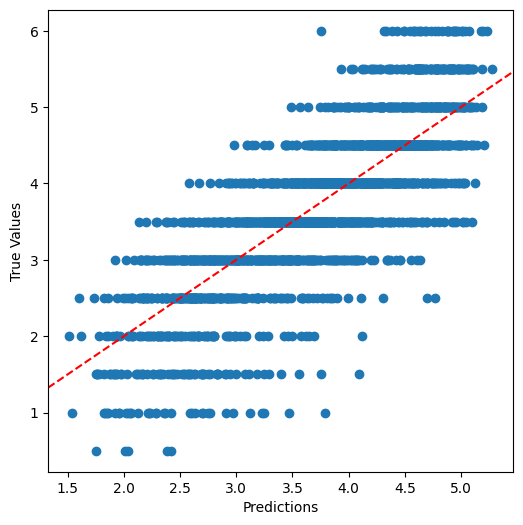

In [32]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(means, train_scores_df['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

(array([159., 637., 762., 492., 276., 103.,  24.,  13.,   3.,   2.]),
 array([0.00909278, 0.03205798, 0.05502317, 0.07798836, 0.10095356,
        0.12391875, 0.14688395, 0.16984914, 0.19281434, 0.21577953,
        0.23874472]),
 <BarContainer object of 10 artists>)

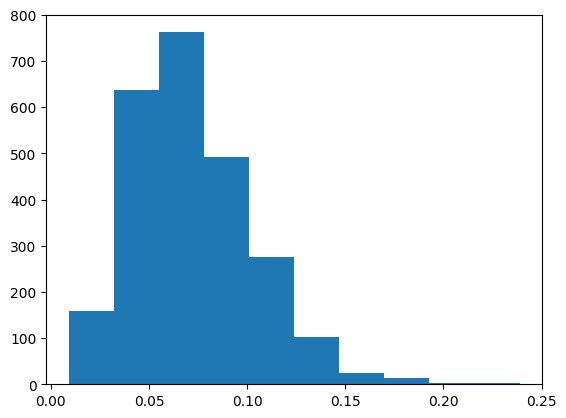

In [33]:
plt.hist(stds)

## Analyze models

In [34]:
split_importance = models_dict['0_0'].feature_importances_

# Plot feature importance using Gain
# lgb.plot_importance(models_dict['0_0'], importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
# plt.show()

In [35]:
split_importance_df = pd.DataFrame({'Feature': train_cols, 'Split': split_importance})
print(split_importance_df.sort_values(by='Split', ascending=False))

                                Feature  Split
408                        sent_len_sum     59
302                  down_event_8_count     48
297                  down_event_3_count     31
334                 text_change_8_count     30
2536  cursor_position_abs_change50_last     27
...                                 ...    ...
1542          rolling_std_30_<lambda_7>      0
1544         rolling_std_30_<lambda_10>      0
1545         rolling_std_30_<lambda_11>      0
1546         rolling_std_30_<lambda_12>      0
3594                      pauses_20_sec      0

[3595 rows x 2 columns]


## Reduced feature list

In [36]:
temp_cols = []
for k in models_dict.keys():
    temp = models_dict[k].feature_importances_
    temp_df = pd.DataFrame({'Feature': train_cols, 'Split': temp})
    temp_cols+=list(temp_df.sort_values(by='Split', ascending=False).loc[:np.ceil(temp_df.shape[0]*0.75)]['Feature'].values)
# list(split_importance_df.sort_values(by='Split', ascending=False).loc[:np.ceil(split_importance_df.shape[0]*0.75)]['Feature'].values)

new_train_cols = list(set(temp_cols))

In [37]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in new_train_cols if col not in target_col + drop_cols]

In [38]:
def objective(trial,data=train_feats[train_cols],target=train_feats[target_col]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20,25,30,35,40,45,50]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [9,11,13,15,17,20,25,30,35,40,45,50]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40, step=2)
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': 42,
        "n_estimators" : 10000,
        "verbosity": -1,
        "n_jobs": -1,
        # "device_type": 'cuda',
        # "gpu_use_dp": True,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)

    early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
    
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)],  
                callbacks=[early_stopping_callback],
    )
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [39]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-12-04 22:42:44,426] A new study created in memory with name: no-name-277e7e2c-5f76-42c5-b825-11c304a3ef71
[I 2023-12-04 22:43:04,538] Trial 0 finished with value: 0.5835678813677481 and parameters: {'reg_lambda': 1.2416310682730105, 'reg_alpha': 0.9207298246650865, 'colsample_bytree': 0.7, 'colsample_bynode': 0.4, 'subsample': 1.0, 'learning_rate': 0.004329552883749802, 'max_depth': 40, 'min_child_samples': 50, 'num_leaves': 14}. Best is trial 0 with value: 0.5835678813677481.
[I 2023-12-04 22:43:57,942] Trial 1 finished with value: 0.5827234682003812 and parameters: {'reg_lambda': 0.03435274262778796, 'reg_alpha': 2.4275459985516226, 'colsample_bytree': 0.5, 'colsample_bynode': 0.7, 'subsample': 1.0, 'learning_rate': 0.000952795712114569, 'max_depth': 13, 'min_child_samples': 15, 'num_leaves': 10}. Best is trial 1 with value: 0.5827234682003812.
[I 2023-12-04 22:47:27,292] Trial 2 finished with value: 0.6074392976181612 and parameters: {'reg_lambda': 0.03254739626141539, 'reg_

Number of finished trials: 150
Best trial: {'reg_lambda': 0.3429800108155362, 'reg_alpha': 3.194364511840987, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'subsample': 0.9, 'learning_rate': 0.017699188262384626, 'max_depth': 30, 'min_child_samples': 9, 'num_leaves': 12}


In [40]:
study.trials_dataframe().sort_values(by='value', ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bynode,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
145,145,0.574076,2023-12-04 23:40:37.223060,2023-12-04 23:40:43.394825,0 days 00:00:06.171765,0.9,0.6,0.017699,30,9,12,3.194365,0.342980,0.9,COMPLETE
54,54,0.575652,2023-12-04 23:21:02.652005,2023-12-04 23:21:14.556557,0 days 00:00:11.904552,1.0,0.4,0.007230,45,17,10,6.917574,0.117548,0.9,COMPLETE
124,124,0.575964,2023-12-04 23:36:16.817280,2023-12-04 23:36:30.947154,0 days 00:00:14.129874,1.0,0.4,0.005969,30,9,12,9.963699,0.276488,0.9,COMPLETE
136,136,0.576182,2023-12-04 23:39:23.976717,2023-12-04 23:39:35.093411,0 days 00:00:11.116694,1.0,0.6,0.012647,30,9,10,6.314529,0.974768,0.9,COMPLETE
125,125,0.576728,2023-12-04 23:36:30.948154,2023-12-04 23:36:48.521055,0 days 00:00:17.572901,1.0,0.8,0.008223,13,9,14,8.465590,0.342354,0.9,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,7,0.593613,2023-12-04 22:57:26.264460,2023-12-04 22:57:36.510887,0 days 00:00:10.246427,0.7,0.8,0.029422,11,25,28,0.000383,0.003108,0.6,COMPLETE
2,2,0.607439,2023-12-04 22:43:57.943956,2023-12-04 22:47:27.291668,0 days 00:03:29.347712,1.0,1.0,0.000211,9,40,14,0.255294,0.032547,0.6,COMPLETE
9,9,0.644155,2023-12-04 22:57:43.159823,2023-12-04 23:05:35.025058,0 days 00:07:51.865235,0.9,0.7,0.000137,45,15,36,0.000120,0.005253,1.0,COMPLETE
4,4,0.665031,2023-12-04 22:47:42.165219,2023-12-04 22:51:22.048615,0 days 00:03:39.883396,0.5,0.8,0.000117,9,40,18,0.009382,0.000190,1.0,COMPLETE


## Test best model

In [53]:
len(train_cols)

3209

In [55]:
import pickle

with open('reduced_train_cols.pkl', 'wb') as f:
    pickle.dump(train_cols, f)

In [41]:
best_trial = study.best_trial.params
print(best_trial)

{'reg_lambda': 0.3429800108155362, 'reg_alpha': 3.194364511840987, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'subsample': 0.9, 'learning_rate': 0.017699188262384626, 'max_depth': 30, 'min_child_samples': 9, 'num_leaves': 12}


In [42]:
OOF_PREDS = np.zeros((len(train_feats), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in train_logs_df['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        best_params = {
                "objective": "rmse",
                "metric": "rmse",
                'random_state': 42,
                "n_estimators" : 10000,
                "verbosity": -1,
                "n_jobs": -1,
                **best_trial
            }
        model = lgb.LGBMRegressor(**best_params)
        early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback],
        )

        valid_predict = model.predict(X_valid)

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_PREDS[valid_idx, 0] = valid_predict 


        # test_predict = model.predict(X_test)
        # TEST_PREDS[:, 0] += test_predict / 5 / 10
        # test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

In [43]:
means = []
stds = []

for idx in preds_dict:
    means.append(np.mean(preds_dict[idx]))
    stds.append(np.std(preds_dict[idx]))
    
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   means,
                                                                   squared=False)))

OOF metric LGBM = 0.61374


## Quantiles

In [44]:
# OOF_PREDS1 = np.zeros((len(train_feats), 1))
# OOF_PREDS2 = np.zeros((len(train_feats), 1))
# OOF_PREDS3 = np.zeros((len(train_feats), 1))
# # TEST_PREDS = np.zeros((len(test_feats), 2))

# models_dict = {}
# scores = []
# preds_dict = {}
# preds_dict['0.1'] = {}
# preds_dict['0.5'] = {}
# preds_dict['0.9'] = {}


# for i in [0.1,0.5,0.9]:
#     count = 0
#     for _ in train_logs_df['id'].unique():
#         preds_dict[str(i)][count] = []
#         count+=1

# # test_predict_list = []

# for i in range(5):
#     kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
#     oof_valid_preds = np.zeros(train_feats.shape[0])
#     # X_test = test_feats[train_cols]
#     for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
#         X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
#         X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
#         best_params = {
#                 "objective": "quantile",
#                 "metric": "rmse",
#                 'random_state': 42+i,
#                 # "n_estimators" : 12001,
#                 "verbosity": -1,
#                 "n_jobs": -1,
#                 **best_trial
#             }
        
#         for alpha_, oof_ in zip([0.1, 0.5, 0.9], [OOF_PREDS1, OOF_PREDS2, OOF_PREDS3]):
#             model = lgb.LGBMRegressor(**best_params, alpha=alpha_)
#             early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
            
#             model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
#                     callbacks=[early_stopping_callback],
#             )

#             valid_predict = model.predict(X_valid)

#             for count, idx in enumerate(valid_idx):
#                 preds_dict[str(alpha_)][idx].append(valid_predict[count])

#             # oof_valid_preds[valid_idx] = valid_predict
#             # OOF_PREDS[valid_idx, 0] += valid_predict / 5
#             oof_[valid_idx, 0] = valid_predict


#             # test_predict = model.predict(X_test)
#             # TEST_PREDS[:, 0] += test_predict / 5 / 10
#             # test_predict_list.append(test_predict)
#             # score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
#             models_dict[f'{fold}_{i}'] = model

#     # oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
#     # scores.append(oof_score)

In [45]:
# means = []
# stds = []

# for idx in preds_dict['0.9']:
#     means.append(np.mean(preds_dict['0.9'][idx]))
#     stds.append(np.std(preds_dict['0.9'][idx]))

In [46]:
# print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
#                                                                    means,
#                                                                    squared=False)))

OOF metric LGBM = 1.20673


## Analyze errors

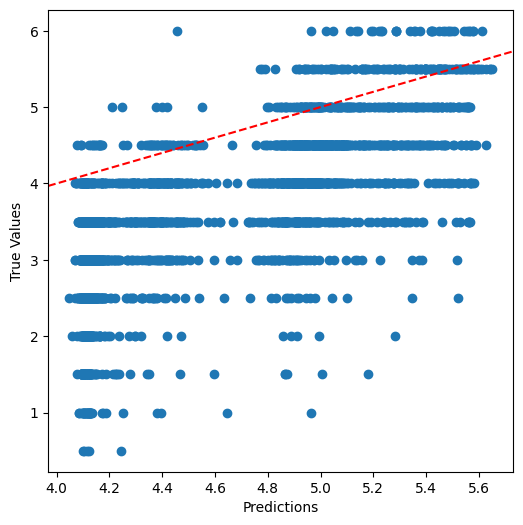

In [47]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(means, train_scores_df['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

(array([491., 955., 596., 248., 101.,  36.,  23.,  12.,   7.,   2.]),
 array([0.00259067, 0.01846898, 0.03434728, 0.05022559, 0.0661039 ,
        0.0819822 , 0.09786051, 0.11373881, 0.12961712, 0.14549542,
        0.16137373]),
 <BarContainer object of 10 artists>)

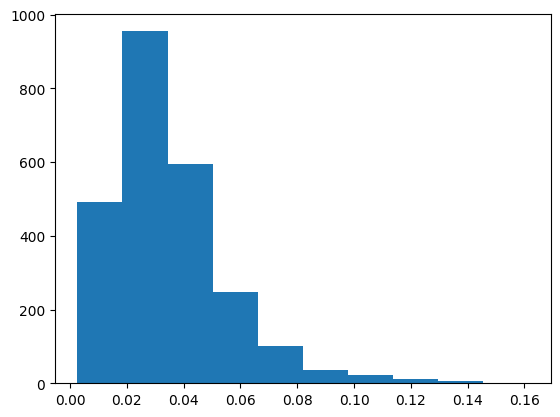

In [48]:
plt.hist(stds)

In [49]:
x = pd.DataFrame()
x['means'] = means
x['stds'] = stds
x['target'] = train_scores_df['score']

In [50]:
x['residuals'] = np.abs(x['means'] - x['target'])

In [51]:
x.sort_values(by='stds', ascending=False, inplace=True)

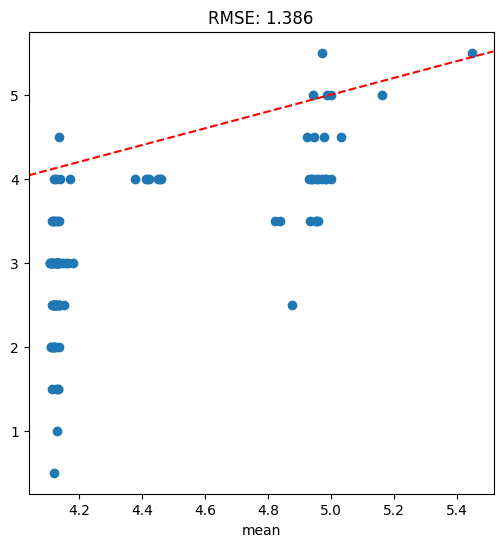

In [52]:
f, ax = plt.subplots(figsize=(6, 6))

x_ = x['means'].tail(100)
# x_ = round_to_half(x_, round_up=True)
y = x['target'].tail(100)

mse = metrics.mean_squared_error(x_, y, squared=False)

ax.scatter(x_, y)
plt.xlabel('mean')
plt.title(f'RMSE: {mse:.3f}')
add_identity(ax, color='r', ls='--')
plt.show()